In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# GOAL: Define Demand Proxies

- **Occupancy Rates** e.g., per month, per week, per day, etc
- **Booked nights** e.g., over a window
- **Probability of Booking**

In [ ]:
listing = pd.read_csv('/content/listing_level')

In [ ]:
booking = pd.read_csv('/content/booking_level_csv')

In [ ]:
calendar = pd.read_csv('/content/calendar_level_csv')

In [ ]:
booking.tail()

,listing_id,booking_id,booking_start_date,stay_length,start_date,end_date
19695,861857172153830345,10.0,2025-06-19,3.0,2025-06-19,2025-06-21
19696,861857172153830345,11.0,2025-07-03,5.0,2025-07-03,2025-07-07
19697,861857172153830345,12.0,2025-07-09,4.0,2025-07-09,2025-07-12
19698,861857172153830345,13.0,2025-07-17,3.0,2025-07-17,2025-07-19
19699,861857172153830345,14.0,2025-07-22,4.0,2025-07-22,2025-07-25


# Booking Probability

What is the probability this listing was booked, given its price?

Can model demand as a logit-style probability problem using this.

In [ ]:
supply_calendar_listings = calendar.loc[lambda x: x.date >= '2025-07-26'] # any listing on or after this date represents supply
demand_calendar_listings = calendar.loc[lambda x: x.date < '2025-07-26']

In [ ]:
supply_calendar_listings.to_csv('supply_calendar_listings_level.csv', index=False)
demand_calendar_listings.to_csv('demand_calendar_listings_level.csv', index=False)

**supply_calendar_listings** represents future supply and can be used later for forecasting or LLM text analysis etc.

**demand_calendar_listings** will be used to validate demand proxies (occupancy rates,

In [ ]:
demand_calendar_listings.head()

,listing_id,date,available,minimum_nights,maximum_nights,price,booked,new_booking,booking_seq,booking_id,stay_length,start_date,end_date
0,3686,2025-03-13,True,1,365,67.0,0,False,0,NaN,NaN,NaN,NaN
1,3686,2025-03-14,True,31,365,67.0,0,False,0,NaN,NaN,NaN,NaN
2,3686,2025-03-15,True,31,365,67.0,0,False,0,NaN,NaN,NaN,NaN
3,3686,2025-03-16,True,31,365,67.0,0,False,0,NaN,NaN,NaN,NaN
4,3686,2025-03-17,True,31,365,67.0,0,False,0,NaN,NaN,NaN,NaN


ASSUMPTIONS:
- all listings in the "demand_calendar_listings" table represent realized historical demand.
- Therefore, if booked=1 for these listings, this is realized demand
- If booked=0, the listing was available but never booked.

## Overall Probability

Mean probability a listings is booked on any given day during the window of demand

In [ ]:
demand_calendar_listings.groupby('listing_id').agg(
    overall_booking_prob=('booked', 'mean')
)

,overall_booking_prob
listing_id,
3686,0.000000
3943,0.118519
4197,0.096296
4529,0.007407
5589,0.162963
...,...
860220926209205933,0.422222
860221913422816642,1.000000
860282990382751022,0.918519


In [ ]:
demand_calendar_listings = demand_calendar_listings.join(demand_calendar_listings.groupby('listing_id').agg(
    overall_booking_prob=('booked', 'mean')
), on='listing_id', how='left')

# Occupancy Rate

To model quanty demanded per period (e.g., day, week, month). Suitable for linear, exponential and/or constant-elasticity price response modeling functions.

**Booking-level** data can be used for:
 - Computing occupancy rates
 - Measuring revenue per listing per week
 - Understanding seanonal patters

In [ ]:
booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19700 entries, 0 to 19699
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   listing_id          19700 non-null  int64  
 1   booking_id          19700 non-null  float64
 2   booking_start_date  19700 non-null  object 
 3   stay_length         19700 non-null  float64
 4   start_date          19700 non-null  object 
 5   end_date            19700 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 923.6+ KB


In [ ]:
booking = booking.assign(
    booking_start_date=lambda x: pd.to_datetime(x.booking_start_date),
    start_date=lambda x: pd.to_datetime(x.start_date),
    end_date=lambda x: pd.to_datetime(x.end_date)
)

In [ ]:
booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19700 entries, 0 to 19699
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   listing_id          19700 non-null  int64         
 1   booking_id          19700 non-null  float64       
 2   booking_start_date  19700 non-null  datetime64[ns]
 3   stay_length         19700 non-null  float64       
 4   start_date          19700 non-null  datetime64[ns]
 5   end_date            19700 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(1)
memory usage: 923.6 KB


# Merging booking level data with relevant (demand) calendar and listing data features to begin modeling demand and price response functions.

Modeling how demand (bookings) respond to PRICE and (useful) LISTING characteristics. Merging should:
 - combine stable attributes such as property type, bedroom, host quality with booking data
 - avoid text heavy, noisy fields (URLS, etc)

In [ ]:
np.sort(listing.columns)

array(['accommodates', 'amenities', 'availability_30', 'availability_365',
       'availability_60', 'availability_90', 'availability_eoy',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'calendar_updated',
       'description', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'first_review', 'has_availability',
       'host_about', 'host_acceptance_rate', 'host_has_profile_pic',
       'host_identity_verified', 'host_is_superhost',
       'host_listings_count', 'host_name', 'host_response_rate',
       'host_response_time', 'host_since', 'host_total_listings_count',
       'host_verifications', 'instant_bookable', 'last_review',
       'latitude', 'listing_id', 'longitude', 'maximum_nights',
       'maximum_nights_avg_ntm', 'minimum_nights',
       'minimum_ni

In [ ]:
merge_cols = [
    'listing_id', 'price', 'property_type', 'room_type', 'accommodates',
    'bedrooms', 'beds', 'bathrooms', 'minimum_nights', 'maximum_nights',
    'availability_30', 'availability_90', 'availability_365',
    'host_is_superhost', 'host_response_rate', 'host_acceptance_rate',
    'instant_bookable', 'review_scores_rating', 'review_scores_cleanliness',
    'review_scores_location', 'review_scores_value', 'number_of_reviews',
    'latitude', 'longitude', 'neighbourhood_cleansed'
]

In [ ]:
demand_calendar_listings.head().iloc[:,-1]

,overall_booking_prob
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
booking_merged = booking.merge(listing[merge_cols], on='listing_id', how='left')

In [ ]:
complete_booking = booking_merged.merge(demand_calendar_listings[['listing_id','overall_booking_prob']],
                                              on='listing_id', how='left')

# Adding seasonal descriptive features to COMPLETE BOOKING DATA

In [ ]:
complete_booking = complete_booking.assign(
    month = pd.to_datetime(complete_booking.booking_start_date).dt.month,
    day_of_week = pd.to_datetime(complete_booking.booking_start_date).dt.dayofweek,
    is_weekend = lambda x: x.day_of_week.isin([5,6])
)

In [ ]:
# complete_booking.to_csv('complete_booking_level.csv', index=False)

In [ ]:
np.sort(complete_booking.columns)

array(['accommodates', 'availability_30', 'availability_365',
       'availability_90', 'bathrooms', 'bedrooms', 'beds', 'booking_id',
       'booking_start_date', 'day_of_week', 'end_date',
       'host_acceptance_rate', 'host_is_superhost', 'host_response_rate',
       'instant_bookable', 'is_weekend', 'latitude', 'listing_id',
       'longitude', 'maximum_nights', 'minimum_nights', 'month',
       'neighbourhood_cleansed', 'number_of_reviews',
       'overall_booking_prob', 'price', 'property_type',
       'review_scores_cleanliness', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'room_type',
       'start_date', 'stay_length'], dtype=object)

# Demand Visualization and Pre-Modeling

## Distribution of Realized Booking/Demand vs Price

How many bookings occurred at each price level.

In [ ]:
np.sort(complete_booking.columns)

array(['accommodates', 'availability_30', 'availability_365',
       'availability_90', 'bathrooms', 'bedrooms', 'beds', 'booking_id',
       'booking_start_date', 'day_of_week', 'end_date',
       'host_acceptance_rate', 'host_is_superhost', 'host_response_rate',
       'instant_bookable', 'is_weekend', 'latitude', 'listing_id',
       'longitude', 'maximum_nights', 'minimum_nights', 'month',
       'neighbourhood_cleansed', 'number_of_reviews',
       'overall_booking_prob', 'price', 'property_type',
       'review_scores_cleanliness', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'room_type',
       'start_date', 'stay_length'], dtype=object)

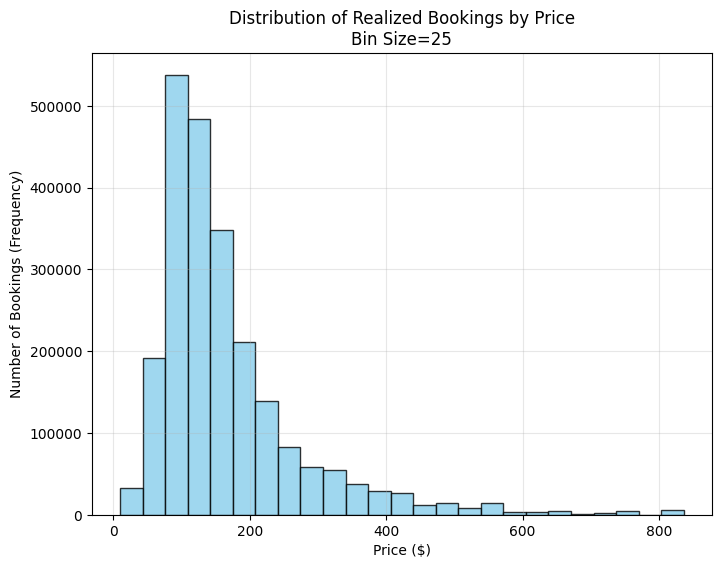

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(
    complete_booking.price, bins=25,
    color='skyblue', edgecolor='black',
    alpha=0.8
)

plt.title('Distribution of Realized Bookings by Price\nBin Size=25')
plt.xlabel('Price ($)')
plt.ylabel('Number of Bookings (Frequency)')
plt.grid(True, alpha=0.3)
plt.show()



To convert bar's height to an approximate PERCENTAGE OF BOOKINGS GIVEN PRICE you multiply the height (e.g., 0.007) by the bin width (25) * 100.


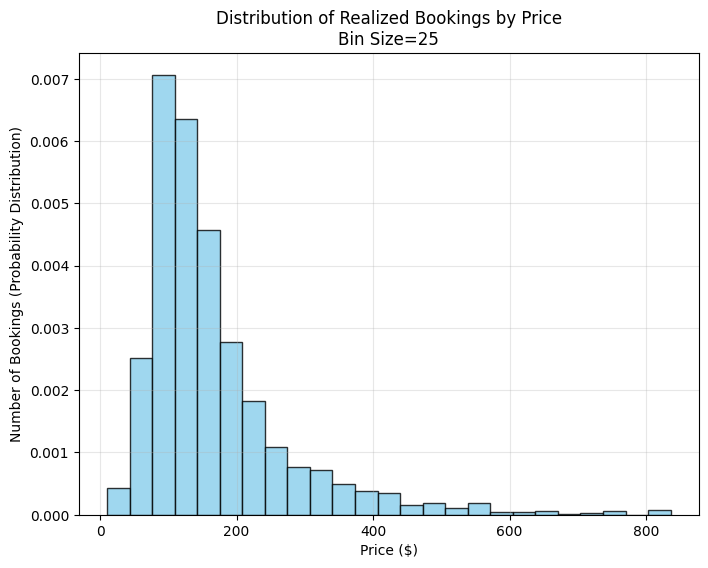

In [ ]:
print("To convert bar's height to an approximate PERCENTAGE OF BOOKINGS GIVEN PRICE you multiply the height (e.g., 0.007) by the bin width (25) * 100.")
plt.figure(figsize=(8,6))
plt.hist(
    complete_booking.price,
    density=True, bins=25,
    color='skyblue', edgecolor='black',
    alpha=0.8
)

plt.title('Distribution of Realized Bookings by Price\nBin Size=25')
plt.xlabel('Price ($)')
plt.ylabel('Number of Bookings (Probability Distribution)')
plt.grid(True, alpha=0.3)
plt.show()

To convert bar's height to an approximate **percentage of bookings** you multiply the height (e.g., 0.007) by the bin width (25) * 100.

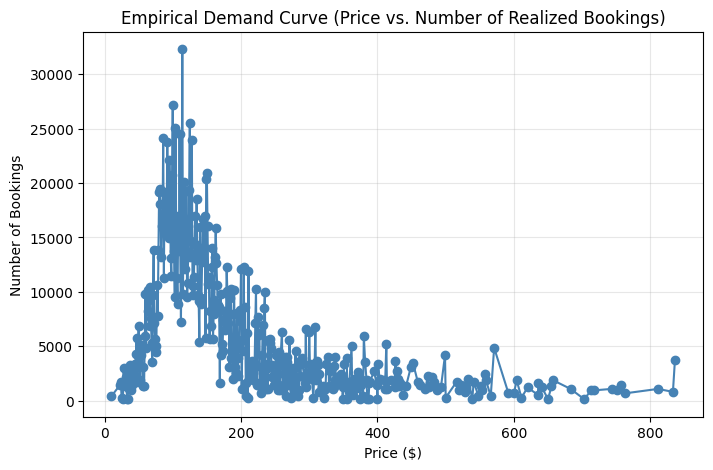

In [ ]:
# Aggregating by unique price
demand_curve_raw = (
    complete_booking
    .groupby('price', as_index=False)
    .agg(num_bookings=('booking_id', 'count'))
    .sort_values('price')
)

plt.figure(figsize=(8,5))
plt.plot(demand_curve_raw['price'], demand_curve_raw['num_bookings'], marker='o', linestyle='-', color='steelblue')
plt.title('Empirical Demand Curve (Price vs. Number of Realized Bookings)')
plt.xlabel('Price ($)')
plt.ylabel('Number of Bookings')
plt.grid(True, alpha=0.3)
plt.show()


Each point represents the total number of bookings that occured at that specific price.

# Creating a revenue feature so we can directly model SALES PERFORMANCE

In [ ]:
pd.set_option('display.max_columns', len(complete_booking.columns))

In [ ]:
complete_booking = complete_booking.assign(
    revenue = lambda x: x.price * x.stay_length
) # revenue generated for each booking

In [ ]:
complete_booking.to_csv('complete_booking_v2.csv', index=False)